In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
## Get images from UTKFace at https://susanqq.github.io/UTKFace/
## In-the-wild version was used for these models
## Based on code found on https://github.com/serengil/tensorflow-101

#os.chdir(r'C:\Users\user\') # change it to the path that contains table(mat).csv
df = pd.read_csv('utk_uncropped_all/utkCrop_no16.csv', usecols=['age', 'gender', 'race', 'date&time', 'filename'])
df.dropna(inplace=True)



In [3]:
df.head()

,age,gender,race,date&time,filename
0,100,0.0,0,20170112213500903,100_0_0_20170112213500903.jpg
1,100,0.0,0,20170112215240346,100_0_0_20170112215240346.jpg
2,100,1.0,0,20170110183726390,100_1_0_20170110183726390.jpg
3,100,1.0,0,20170112213001988,100_1_0_20170112213001988.jpg
4,100,1.0,0,20170112213303693,100_1_0_20170112213303693.jpg


In [4]:
df = df.drop(columns = 'date&time')

In [5]:
df.head()

,age,gender,race,filename
0,100,0.0,0,100_0_0_20170112213500903.jpg
1,100,0.0,0,100_0_0_20170112215240346.jpg
2,100,1.0,0,100_1_0_20170110183726390.jpg
3,100,1.0,0,100_1_0_20170112213001988.jpg
4,100,1.0,0,100_1_0_20170112213303693.jpg


In [6]:
#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]

#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

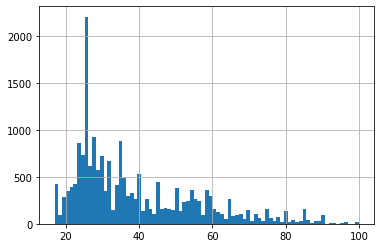

In [7]:
histogram = df['age'].hist(bins=df['age'].nunique())

In [8]:
classes = 101 #(0, 100])
print("number of output classes: ",classes)

number of output classes:  101


In [9]:
target_size = (224, 224)

def getImagePixels(image_path):
    img = image.load_img("utk_uncropped_all/%s" % image_path, grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [10]:
df['pixels'] = df['filename'].apply(getImagePixels)

In [11]:
df.head()

,age,gender,race,filename,pixels
0,100,0.0,0,100_0_0_20170112213500903.jpg,"[51.0, 55.0, 64.0, 82.0, 86.0, 95.0, 73.0, 77...."
1,100,0.0,0,100_0_0_20170112215240346.jpg,"[113.0, 117.0, 126.0, 113.0, 117.0, 126.0, 114..."
2,100,1.0,0,100_1_0_20170110183726390.jpg,"[226.0, 229.0, 236.0, 232.0, 235.0, 242.0, 227..."
3,100,1.0,0,100_1_0_20170112213001988.jpg,"[65.0, 72.0, 80.0, 65.0, 72.0, 80.0, 65.0, 72...."
4,100,1.0,0,100_1_0_20170112213303693.jpg,"[31.0, 36.0, 40.0, 31.0, 36.0, 40.0, 31.0, 36...."


In [12]:
target = df['age'].values
target_classes = keras.utils.to_categorical(target, classes)

In [13]:
tr_x, ts_x, train_y, test_y = train_test_split(df, target_classes
                                        , test_size=0.30, random_state=42)#, stratify=target_classes)

In [14]:
##Use these for duplicating or triplicating >= 60 (balancing the data)
#tr_60 = tr_x[tr_x['age'] >= 60]
#tr_y60 = train_y[tr_x['age'] >= 60]

In [15]:
##Use these for duplicating 
# tr_x = tr_x.append(tr_60)
# train_y = np.concatenate((train_y, tr_y60))

In [16]:
##Use these for triplicating > 60
# tr_x = tr_x.append(tr_60)
# tr_x = tr_x.append(tr_60)
# train_y = np.concatenate((train_y, tr_y60))
# train_y = np.concatenate((train_y, tr_y60))

In [17]:
##Use these for duplicating or triplicating
#histogram = tr_x['age'].hist(bins=tr_x['age'].nunique())

In [18]:
#features = df['pixels'].values
features = []

for i in range(0, tr_x.shape[0]):
    features.append(tr_x['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [19]:
#features = df['pixels'].values
features_test = []

for i in range(0, ts_x.shape[0]):
    features_test.append(ts_x['pixels'].values[i])

features_test = np.array(features_test)
features_test = features_test.reshape(features_test.shape[0], 224, 224, 3)

In [20]:
features.shape


(13799, 224, 224, 3)

In [21]:
features_test.shape

(5915, 224, 224, 3)

In [22]:
features /= 255 #normalize in [0, 1]
features_test /= 255

In [23]:
train_x = features
test_x = features_test

In [24]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [25]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('vgg_face_weights.h5')

In [26]:
#freeze all layers of VGG-Face except last 7
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

In [27]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)

    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [28]:
#Choose between Adam and sgd optimizer, usually Adam converges after 30 epochs, Sgd over 250 still not converging.
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [29]:
checkpointer = ModelCheckpoint(
    filepath='classification_age_model_utk.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [30]:
scores = []

In [32]:
#True retrains the NN
enableFit = False

if enableFit:
    epochs = 100
    batch_size = 512

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model("classification_age_model_utk.hdf5")
    
    age_model.save_weights('age_model_weights_utk.h5')
        
else:
    ##Rename accordingly if needed:
    #pre-trained weights for age prediction (Wiki): https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    #pre-trained weights for age prediction (UTK):https://drive.google.com/file/d/10-S6IIkahO4f1BBsVPPcB8Z4V4tepb6c/view?usp=sharing
    #pre-trained weights for age prediction with 2x 60+ people: https://drive.google.com/file/d/10-0W2subbpH_ZmUopdEAt9barSEWyyQX/view?usp=sharing
    #pre-trained weights for age prediction with 3x 60+ people:https://drive.google.com/file/d/1hp6uy01YKu-USMo_ef60MtCNL8bJUlP-/view?usp=sharing
    age_model.load_weights("age_model_weights_utk.h5")

In [ ]:
#Only prints if model is trained
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.rcParams["figure.figsize"] = (20,15)
plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

# Model evaluation on test set

In [33]:
#loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

5915/5915 [==============================] - 48s 8ms/step


[3.502568178829861, 0.12071005917537646]

In [34]:
predictions = age_model.predict(test_x)

In [35]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [36]:
ts_x['Weighted_Avg'] = apparent_predictions
argmax = []
for p in predictions: 
    predm = np.argmax(p)
    argmax.append(predm)
ts_x['ArgMax'] = argmax

C:\Users\sebas\.conda\envs\jerry\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sebas\.conda\envs\jerry\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
ts_x

,age,gender,race,filename,pixels,Weighted_Avg,ArgMax
4531,26,0.0,4,26_0_4_20170117153320853.jpg,"[156.0, 161.0, 167.0, 156.0, 161.0, 167.0, 156...",29.530177,26
12550,40,0.0,0,40_0_0_20170117133805950.jpg,"[206.0, 206.0, 206.0, 206.0, 206.0, 206.0, 206...",39.752235,40
488,19,0.0,2,19_0_2_20170116212031170.jpg,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255...",30.157920,22
7561,29,0.0,2,29_0_2_20170116172141170.jpg,"[250.0, 251.0, 253.0, 250.0, 251.0, 253.0, 250...",27.181044,23
5000,26,1.0,1,26_1_1_20170116153419888.jpg,"[136.0, 138.0, 135.0, 136.0, 138.0, 135.0, 136...",27.079226,26
...,...,...,...,...,...,...,...
5104,26,1.0,1,26_1_1_20170116231832606.jpg,"[175.0, 182.0, 190.0, 174.0, 181.0, 189.0, 174...",30.061464,22
11872,37,1.0,4,37_1_4_20170117203627007.jpg,"[199.0, 167.0, 120.0, 199.0, 167.0, 120.0, 199...",32.829794,26
10843,35,1.0,0,35_1_0_20170117152140763.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29.983485,23
5747,26,1.0,4,26_1_4_20170117143809650.jpg,"[200.0, 140.0, 116.0, 211.0, 153.0, 129.0, 209...",24.077150,23


In [38]:
mae = 0

for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    
    abs_error = abs(prediction - actual)
#     actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  7.7565511411665256
instances:  5915


In [46]:
#Choose the output according to your code
#ts_x.to_csv('utk_uncropped_retrained_age_adam_with_dup.csv')
#ts_x.to_csv('utk_uncropped_retrained_age_adam_with_dup_x3.csv')
#ts_x.to_csv('error_wiki_test_utk_adam.csv')
#ts_x.to_csv('utk_uncropped_retrained_age_adam_with_dup_x3.csv')

# Error Measurement for Train Set

In [41]:
predictions = age_model.predict(train_x)

In [42]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [43]:
mae = 0

for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(train_y[i])
    
    abs_error = abs(prediction - actual)
#     actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  6.9188319975496455
instances:  19589


# Testing model on a custom image

Feed an image to find the apparent age

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [ ]:
#Add your own pictures to test
picture = "S1.jpg"
prediction = age_model.predict(loadImage(picture))

In [ ]:
y_pos = np.arange(101)
plt.bar(y_pos, prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show()

In [ ]:
img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

print("most dominant age class (not apparent age): ",np.argmax(prediction))

apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
print("apparent age: ", int(apparent_age[0]))